<a href="https://www.kaggle.com/code/lalit7881/e-commerce-sales-prediction-accuracy-100?scriptVersionId=296657743" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/e-commerce-sales-performance-analysis/ecommerce_sales_data.csv


## Import dataset

In [2]:
df = pd.read_csv("/kaggle/input/e-commerce-sales-performance-analysis/ecommerce_sales_data.csv")

In [3]:
df.head()

,Order Date,Product Name,Category,Region,Quantity,Sales,Profit
0,2024-12-31,Printer,Office,North,4,3640,348.93
1,2022-11-27,Mouse,Accessories,East,7,1197,106.53
2,2022-05-11,Tablet,Electronics,South,5,5865,502.73
3,2024-03-16,Mouse,Accessories,South,2,786,202.87
4,2022-09-10,Mouse,Accessories,West,1,509,103.28


In [4]:
df.tail()

,Order Date,Product Name,Category,Region,Quantity,Sales,Profit
3495,2023-02-15,Monitor,Accessories,North,4,4064,771.16
3496,2022-09-18,Monitor,Accessories,East,1,1117,119.89
3497,2022-04-12,Laptop,Electronics,South,4,260,66.02
3498,2022-01-18,Printer,Office,South,3,222,50.28
3499,2024-11-01,Smartwatch,Electronics,East,9,10530,1777.32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order Date    3500 non-null   object 
 1   Product Name  3500 non-null   object 
 2   Category      3500 non-null   object 
 3   Region        3500 non-null   object 
 4   Quantity      3500 non-null   int64  
 5   Sales         3500 non-null   int64  
 6   Profit        3500 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 191.5+ KB


In [6]:
df.dtypes

Order Date       object
Product Name     object
Category         object
Region           object
Quantity          int64
Sales             int64
Profit          float64
dtype: object

In [7]:
df.shape

(3500, 7)

In [8]:
df.nunique()

Order Date      1051
Product Name      10
Category           3
Region             4
Quantity           9
Sales           2377
Profit          3447
dtype: int64

In [9]:
df.isnull().sum()

Order Date      0
Product Name    0
Category        0
Region          0
Quantity        0
Sales           0
Profit          0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.columns

Index(['Order Date', 'Product Name', 'Category', 'Region', 'Quantity', 'Sales',
       'Profit'],
      dtype='object')

## Data visualizations

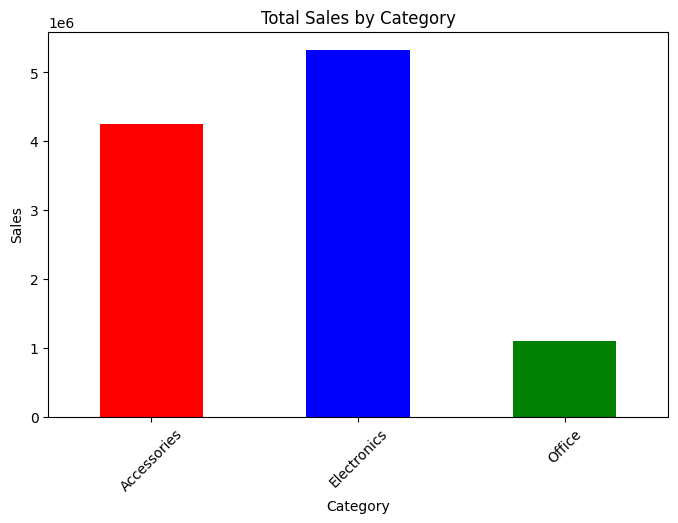

In [12]:
plt.figure(figsize=(8,5))
category_sales = df.groupby('Category')['Sales'].sum()

category_sales.plot(
    kind='bar',
    color=['red', 'blue', 'green', 'orange', 'purple']
)

plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()


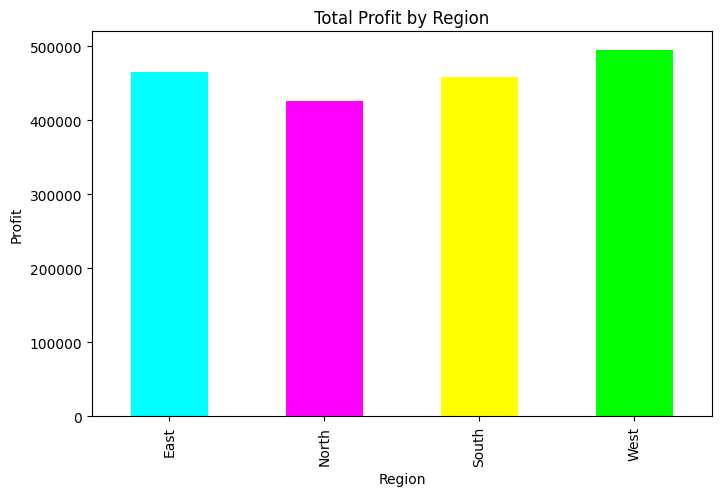

In [13]:
plt.figure(figsize=(8,5))
region_profit = df.groupby('Region')['Profit'].sum()

region_profit.plot(
    kind='bar',
    color=['cyan', 'magenta', 'yellow', 'lime']
)

plt.title('Total Profit by Region')
plt.xlabel('Region')
plt.ylabel('Profit')
plt.show()


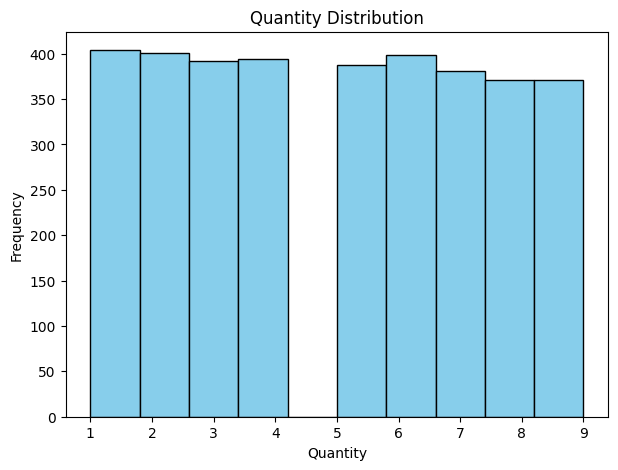

In [14]:
plt.figure(figsize=(7,5))
plt.hist(
    df['Quantity'],
    bins=10,
    color='skyblue',
    edgecolor='black'
)

plt.title('Quantity Distribution')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()


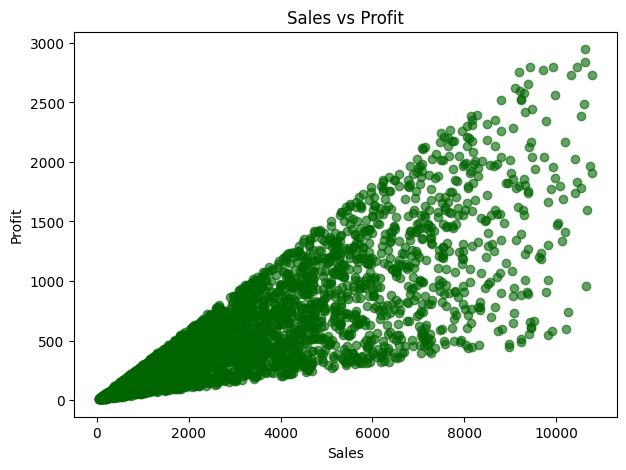

In [15]:
plt.figure(figsize=(7,5))
plt.scatter(
    df['Sales'],
    df['Profit'],
    color='darkgreen',
    alpha=0.6
)

plt.title('Sales vs Profit')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()


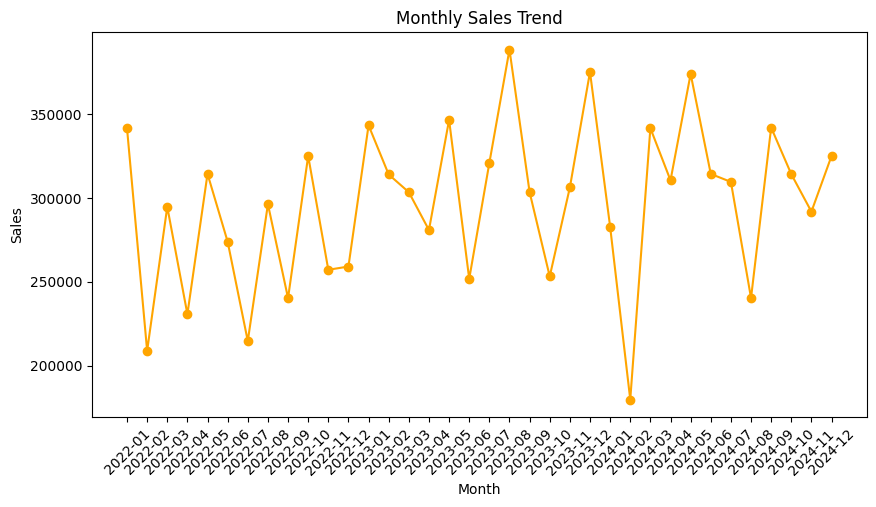

In [16]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
monthly_sales = df.groupby(df['Order Date'].dt.to_period('M'))['Sales'].sum()

plt.figure(figsize=(10,5))
plt.plot(
    monthly_sales.index.astype(str),
    monthly_sales.values,
    color='orange',
    marker='o'
)

plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()


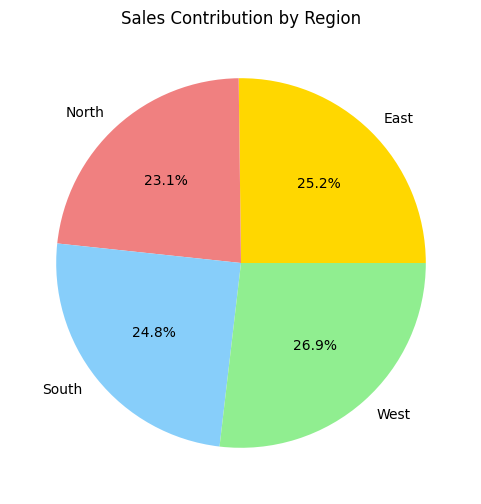

In [17]:
plt.figure(figsize=(6,6))
plt.pie(
    region_profit,
    labels=region_profit.index,
    autopct='%1.1f%%',
    colors=['gold', 'lightcoral', 'lightskyblue', 'lightgreen']
)

plt.title('Sales Contribution by Region')
plt.show()


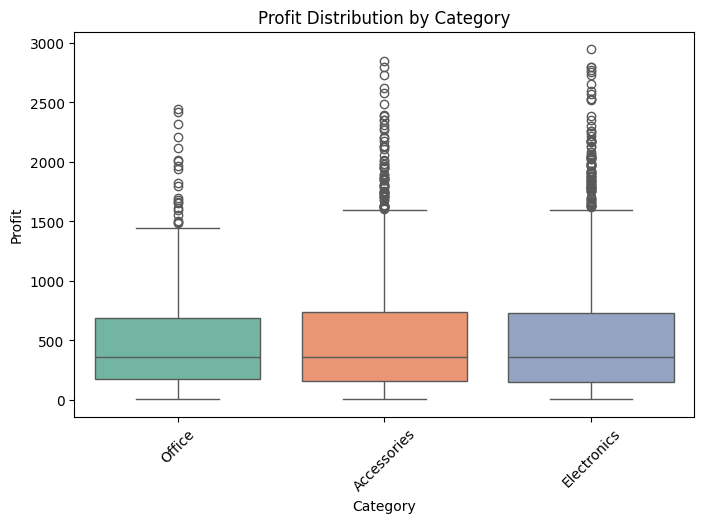

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x='Category',
    y='Profit',
    data=df,
    palette='Set2'
)

plt.title('Profit Distribution by Category')
plt.xticks(rotation=45)
plt.show()


## feature engg

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [20]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Order Date'] = df['Order Date'].dt.month   # extract month


In [21]:
le = LabelEncoder()

df['Product Name'] = le.fit_transform(df['Product Name'])
df['Region'] = le.fit_transform(df['Region'])
df['Category'] = le.fit_transform(df['Category'])


In [22]:
X = df.drop('Category', axis=1)
y = df['Category']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [24]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, lr_pred) * 100, "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_pred))


Logistic Regression Accuracy: 55.08571428571428 %
Confusion Matrix:
 [[170 165   0]
 [137 312   0]
 [  0  91   0]]


In [25]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

print("Decision Tree Accuracy:",
      accuracy_score(y_test, dt_pred) * 100, "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_pred))


Decision Tree Accuracy: 100.0 %
Confusion Matrix:
 [[335   0   0]
 [  0 449   0]
 [  0   0  91]]


In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Accuracy:",
      accuracy_score(y_test, rf_pred) * 100, "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))


Random Forest Accuracy: 100.0 %
Confusion Matrix:
 [[335   0   0]
 [  0 449   0]
 [  0   0  91]]


In [27]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

print("KNN Accuracy:",
      accuracy_score(y_test, knn_pred) * 100, "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_pred))


KNN Accuracy: 46.05714285714286 %
Confusion Matrix:
 [[165 167   3]
 [207 237   5]
 [ 50  40   1]]


In [28]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', LinearSVC(max_iter=5000))
])

svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print("SVM Accuracy:",
      accuracy_score(y_test, svm_pred) * 100, "%")
print("Confusion Matrix:\n", confusion_matrix(y_test, svm_pred))


SVM Accuracy: 52.34285714285715 %
Confusion Matrix:
 [[181 154   0]
 [172 277   0]
 [  0  91   0]]


In [29]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree',
              'Random Forest', 'KNN', 'SVM'],
    'Accuracy (%)': [
        accuracy_score(y_test, lr_pred) * 100,
        accuracy_score(y_test, dt_pred) * 100,
        accuracy_score(y_test, rf_pred) * 100,
        accuracy_score(y_test, knn_pred) * 100,
        accuracy_score(y_test, svm_pred) * 100
    ]
})

print(results)

                 Model  Accuracy (%)
0  Logistic Regression     55.085714
1        Decision Tree    100.000000
2        Random Forest    100.000000
3                  KNN     46.057143
4                  SVM     52.342857


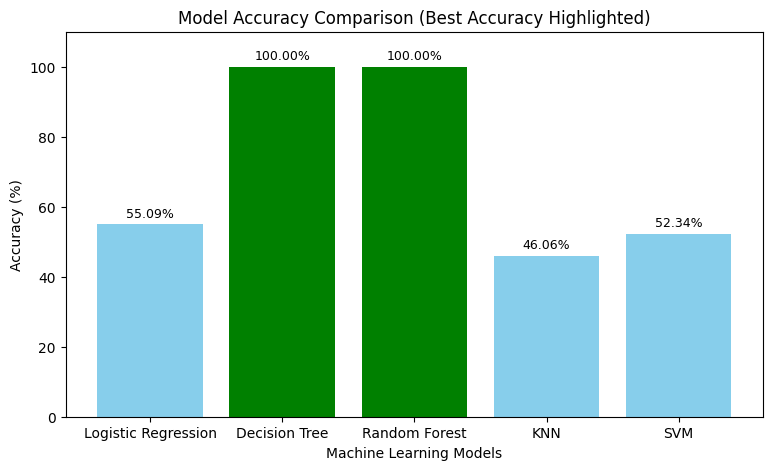

In [30]:
# Accuracy data
data = {
    'Model': ['Logistic Regression', 'Decision Tree',
              'Random Forest', 'KNN', 'SVM'],
    'Accuracy (%)': [55.085714, 100.0, 100.0, 46.057143, 52.342857]
}

df = pd.DataFrame(data)

# Identify best accuracy
max_acc = df['Accuracy (%)'].max()

# Assign colors (highlight best)
colors = ['green' if acc == max_acc else 'skyblue' for acc in df['Accuracy (%)']]

# Plot
plt.figure(figsize=(9, 5))
plt.bar(df['Model'], df['Accuracy (%)'], color=colors)
plt.xlabel("Machine Learning Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison (Best Accuracy Highlighted)")
plt.ylim(0, 110)

# Value labels
for i, val in enumerate(df['Accuracy (%)']):
    plt.text(i, val + 2, f"{val:.2f}%", ha='center', fontsize=9)

plt.show()

## Thank you..pls upvote!!!!!!